# Trajectory Optimization Sandbox

In this notebook we are going to explore different trajectory optimization techniques, we are going to go through the methods in "An Introduction to Trajectory Optimization -- Matthew Kelly".

In [2]:
import numpy as np
from casadi import *
import matplotlib.pyplot as plt

In this notebook we are going to control the same plant, a planar quadrotor with two degrees of freedom. Its equations of motion are given by:


$$m\ddot{x} = -(u_1 + u_2) \sin(\theta)$$
$$m\ddot{y} = (u_1 + u_2) \cos(\theta) - mg$$
$$I\ddot{\theta} = r(u_1 - u_2)$$

## Direct Transcription Method

Euler integration -> piecewise linear state trajectories

In [164]:
import matplotlib.pyplot as plt

# create time vector
# should be: 0.025, 0.05, 0.075, 0.1, 0.2, ...
def build_times(N, base_dt):
    time_vector = [0.0]
    dt = base_dt
    for k in range(1, N + 1):
        if k == 5:
            dt = 1 * dt
        time_vector.append(time_vector[k-1] + dt)
    return time_vector

def build_ballistic_prediction(state, time_vector):
    N = len(time_vector) - 1
    pred = np.empty((4, N))
    pred[:, 0] = state
    for k in range(0, N - 1):
        dt = time_vector[k+1] - time_vector[k]
        pred[0,k+1] = pred[0,k] + dt * state[2]
        pred[1,k+1] = pred[1,k] + dt * state[3]
        pred[2,k+1] = pred[2,k]
        pred[3,k+1] = pred[3,k]
    return pred

def continuous_dynamics(params, x, u):
    m = params["mass"]
    I = params["inertia"]
    g = params["gravity"]
    r = params["radius"]
    return [
       -1.0 / m * (u[0] + u[1]) * np.sin(x[2]),
        1.0 / m * (u[0] + u[1]) * np.cos(x[2]) - g,
        1.0 / I * (u[0] - u[1]) * r,
    ]

class PlanningPolicy:
    """
    Command accelerations to the drone to follow the subject according to the
    desired settings and avoid the obstacle.
    """

    def __init__(self, params):
        self.params = params
        self.N = 28
        self.xdim = 3
        self.udim = 2
        
        self.time_vector = build_times(self.N, self.params['dt'])        

        self.opti = casadi.Opti()
        self.setup_mpc()
    
    def setup_mpc(self):
        #  Setup the optimization variables
        self.x = self.opti.variable(self.xdim, self.N + 1)
        self.u = self.opti.variable(self.udim, self.N)
        self.s = self.opti.variable(1, self.N + 1) # slack variable for ground

        self.x0 = self.opti.parameter(self.xdim, 1)
        self.x_ref = self.opti.parameter(self.xdim, self.N) # parameter for position to track over time

        # Setup the costs here
        Q = casadi.diag(casadi.MX([5.0, 5.0, 0.01]))
        R = casadi.diag(casadi.MX([0.1, 0.1]))
        H_lin = casadi.MX([10.0,])
        H_quad = casadi.diag(casadi.MX([500.0]))

        # Setup cost function
        cost_function = 0
        for k in range(0, self.N):
            # Get the current dt for this timestep
            dt = self.time_vector[k+1] - self.time_vector[k]

            cost_function_k = 0
            # Quadratic state and input costs  
            cost_function_k += (self.x[:,k] - self.x_ref[:,k]).T @ Q @ (self.x[:,k] - self.x_ref[:,k]) + self.u[:,k].T @ R @ self.u[:,k]
            # Linear and quadratic slack variables costs
            cost_function_k += H_lin.T @ self.s[:,k] + self.s[:,k].T @ H_quad @ self.s[:,k]
            # Add to the cost function and scale it appropiately
            cost_function += dt * cost_function_k
        
        for k in range(0, self.N):
            dt = self.time_vector[k+1] - self.time_vector[k]
            # Setup dynamics of the system and use euler integration
            x_dot_k = continuous_dynamics(self.params, self.x[:,k], self.u[:,k])
            self.opti.subject_to(self.x[0,k+1] == self.x[0,k] + dt*x_dot_k[0])
            self.opti.subject_to(self.x[1,k+1] == self.x[1,k] + dt*x_dot_k[1])
            self.opti.subject_to(self.x[2,k+1] == self.x[2,k] + dt*x_dot_k[2])
            
            # Setup slacked constraints
            self.opti.subject_to(self.s[:,k] >= 0.0)
            # Do not hit the floor constraint
#             self.opti.subject_to(self.x[1,k] >= -self.s[0,k])
            self.opti.subject_to(self.x[1,k] >= 0.0)
            # Setup input constraints
            self.opti.subject_to(self.u[:,k] <= self.params['thrust_max'])
            self.opti.subject_to(self.u[:,k] >= -self.params['thrust_max'])

        self.opti.subject_to(self.x[:,0] == self.x0)
        self.opti.minimize(cost_function)
        self.opti.solver('ipopt', {'ipopt.print_level': 0, 'print_time': 0, 'ipopt.sb': 'yes'})
        #self.opti.solver('sqpmethod', {'qpsol': 'osqp'})

    def plan(
        self,
        t: float,
        drone_state : np.ndarray,
      ) -> np.ndarray:
        print(f"t: {t}", end="\r")

        reference = np.empty((self.xdim, self.N))
        for k in range(0, self.N):
            reference[0,k] = 20.0
            reference[1,k] = 5.0
            reference[2,k] = 0.0
        
        self.opti.set_value(self.x_ref, reference)
        self.opti.set_value(self.x0, drone_state)
        sol = self.opti.solve()

        _u = sol.value(self.u)
        _x = sol.value(self.x)
        return np.array(_x), np.array(_u)

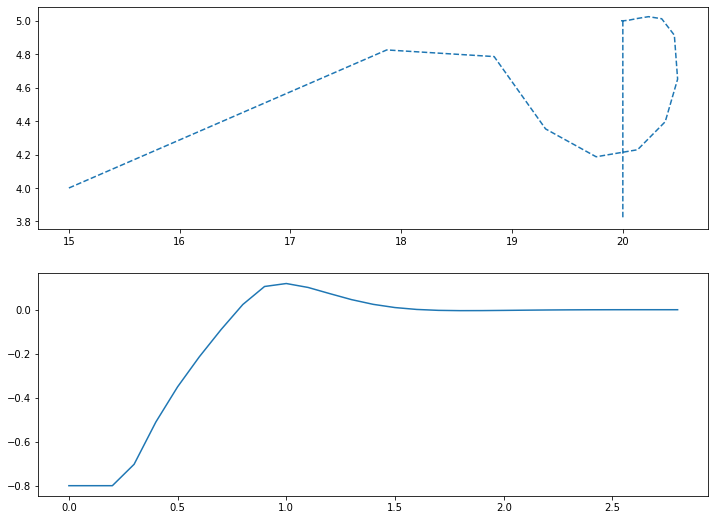

In [177]:
params = dict(
    dt = 0.1,
    thrust_max = 5.0,
    gravity = 9.81,
    inertia = 1.0,
    radius = 0.3,
    mass = 0.5, 
)


policy = PlanningPolicy(params)
states, actions = policy.plan(
    t=0.0,
    drone_state=np.array([15.0, 4.0, -0.8]),
)

fig, ax = plt.subplots(2, 1, figsize=(12, 9))
ax[0].plot(states[0, :], states[1, :], linestyle="dashed")
ax[1].plot(policy.time_vector, states[2, :])

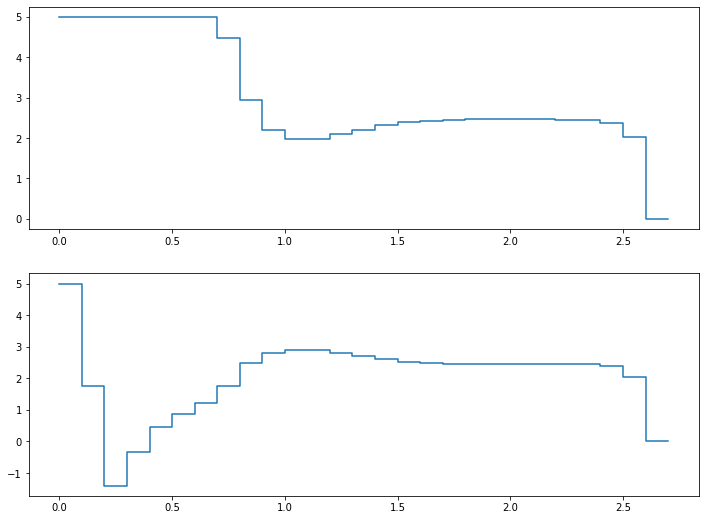

In [224]:
fig, ax = plt.subplots(2, 1, figsize=(12, 9))
ax[0].step(policy.time_vector[:-1], actions[0, :])
ax[1].step(policy.time_vector[:-1], actions[1, :])

In [277]:
import bisect
_states = []
_actions = []
_times = []
_linspaced = np.linspace(0, policy.time_vector[-1], 1000)

dt = policy.time_vector[-1] / 1000

_states.append(states[:, 0])
_times.append(0.0)
state = np.copy(_states[-1])

for i, t in enumerate(_linspaced):    
    k = bisect.bisect_left(policy.time_vector, t)


    prev_t  = 0.0 if i == 0 else _linspaced[i-1]
    state = state + (t - prev_t) * np.array(continuous_dynamics(policy.params, state, actions[:, max(k-1, 0)]))
    _actions.append(actions[:,max(k-1, 0)])
    _states.append(state)
    _times.append(t)

_states = np.array(_states)
_actions = np.array(_actions)

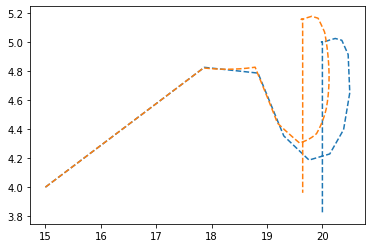

In [278]:
plt.plot(states[0, :], states[1, :], linestyle="dashed")
plt.plot(_states[:, 0], _states[:, 1], linestyle="dashed")

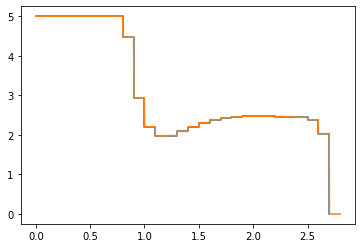

In [282]:
plt.step(policy.time_vector[:-1], actions[0, :], where="post")
plt.plot(_linspaced, _actions[:, 0])

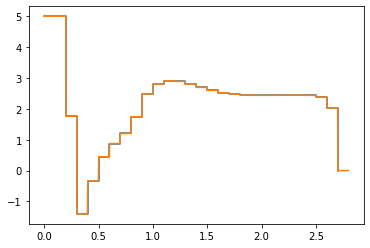

In [283]:
plt.step(policy.time_vector[:-1], actions[1, :], where="post")
plt.plot(_linspaced, _actions[:, 1])